for local:  
start jupyter using:
```
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
```
(I need to run as admin)

and set `run_local = True`

# Setup

In [1]:
run_local = False
download = False

---

In [2]:
import os
import time
import torch

start_time = time.time()

if run_local:
  os.environ['TRANSFORMERS_CACHE'] = "/Users/Martin/.cache/huggingface/transformers"

  %cd "Jupyter Notebook/WS21 NLP (Project)/colab/"
  if download:
    !pip install wget
    !python -m wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip

  data_processing_batch_cpu = 20_000
  data_processing_batch_gpu = 100
  batch_size_hugging = 25
  batch_size_tf = 25
else:
  if download:
    !wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip

  data_processing_batch_cpu = 1_000
  data_processing_batch_gpu = 100
  batch_size_hugging = 50
  batch_size_tf = 50

if torch.cuda.is_available():
  pt_device = torch.device('cuda:0')
else:
  pt_device = torch.device('cpu')

In [3]:
!pip install transformers
!pip install tqdm

from matplotlib import pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy.random import default_rng
from tqdm import tqdm
from pathlib import Path
import shutil
import math
import re
from typing import List, Optional, Union
from collections.abc import Sized
import ast
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Embedding, TimeDistributed
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.models import load_model
from torch.utils.data import Dataset, TensorDataset, DataLoader, IterableDataset
from transformers.trainer_pt_utils import (
    nested_concat,
    find_batch_size,
    nested_numpify,
    nested_truncate
)
from transformers.trainer_utils import (
    EvalLoopOutput,
    PredictionOutput,
    EvalPrediction,
    denumpify_detensorize
)
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    BertConfig,
    EncoderDecoderConfig,
    EncoderDecoderModel,
    Trainer,
    TrainingArguments
)

rng = default_rng()

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
  # does not magically solve all problems, but suprisingly a few.
  tf.config.experimental.set_memory_growth(gpus[0], True)

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 3.3 MB 46.0 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 895 kB 47.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Data processing

## Download

In [ ]:
!unzip python.zip
with open('python_dedupe_definitions_v2.pkl', 'rb') as f:
    py_data = pickle.load(f)
os.remove("python.zip")

os.remove("python_dedupe_definitions_v2.pkl")
os.remove("python_licenses.pkl")

Archive:  python.zip
   creating: python/               
   creating: python/final/         
   creating: python/final/jsonl/   
   creating: python/final/jsonl/train/
  inflating: python/final/jsonl/train/python_train_9.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_12.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_10.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_0.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_6.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_2.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_4.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_8.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_11.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_5.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_13.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_3.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_1.jsonl.g

Only for achieving the same train, val, test split:

In [ ]:
columns_list_short = ['path', 'repo', 'func_name', 'code', 'sha', 'partition']
columns_list = ['path', 'repo', 'func_name', 'code', 'docstring', 'docstring_full', 'sha', 'partition']

def jsonl_list_to_dataframe(file_list, columns=columns_list_short):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f, 
                                   orient='records', 
                                   compression='gzip',
                                   lines=True)[columns] 
                      for f in file_list], sort=False)

In [ ]:
python_files = sorted(Path('python').glob('**/*.gz'))
pydf_split = jsonl_list_to_dataframe(python_files)

shutil.rmtree("python")

## Look at data

In [ ]:
pydf_large = pd.DataFrame(py_data)[['path', 'nwo', 'identifier', 'function', 'docstring_summary', 'docstring', 'sha']]
del py_data

pydf_large['partition']='undefined'
pydf_large.columns = columns_list
pydf_large.columns

Index(['path', 'repo', 'func_name', 'code', 'docstring', 'docstring_full',
       'sha', 'partition'],
      dtype='object')

In [ ]:
pydf_large.iloc[0]

path                               examples/face_recognition_knn.py
repo                                      ageitgey/face_recognition
func_name                                                     train
code              def train(train_dir, model_save_path=None, n_n...
docstring         Trains a k-nearest neighbors classifier for fa...
docstring_full    Trains a k-nearest neighbors classifier for fa...
sha                        c96b010c02f15e8eeb0f71308c641179ac1f19bb
partition                                                 undefined
Name: 0, dtype: object

There is a "sha" column included in the data. We will however not use this value to merge the data, as it is not unique (does not include function name or code).

In [ ]:
len_dup=len(pydf_large[pydf_large.duplicated('sha')])

print(f"Duplicated sha {len_dup/len(pydf_large)* 100:.2f} %")
print(f"Unduplicated sha {(len(pydf_large)-len_dup)/len(pydf_large) * 100:.2f} %")
pydf_large[pydf_large.duplicated('sha')]


Duplicated sha 98.52 %
Unduplicated sha 1.48 %


,path,repo,func_name,code,docstring,docstring_full,sha,partition
1,examples/face_recognition_knn.py,ageitgey/face_recognition,predict,"def predict(X_img_path, knn_clf=None, model_pa...",Recognizes faces in given image using a traine...,Recognizes faces in given image using a traine...,c96b010c02f15e8eeb0f71308c641179ac1f19bb,undefined
2,examples/face_recognition_knn.py,ageitgey/face_recognition,show_prediction_labels_on_image,"def show_prediction_labels_on_image(img_path, ...",Shows the face recognition results visually.,Shows the face recognition results visually.\n...,c96b010c02f15e8eeb0f71308c641179ac1f19bb,undefined
3,examples/web_service_example_Simplified_Chines...,ageitgey/face_recognition,upload_image,def upload_image():\n # 检测图片是否上传成功\n if ...,,,c96b010c02f15e8eeb0f71308c641179ac1f19bb,undefined
4,examples/web_service_example_Simplified_Chines...,ageitgey/face_recognition,detect_faces_in_image,def detect_faces_in_image(file_stream):\n #...,,,c96b010c02f15e8eeb0f71308c641179ac1f19bb,undefined
5,face_recognition/face_detection_cli.py,ageitgey/face_recognition,print_result,"def print_result(filename, location):\n top...",,,c96b010c02f15e8eeb0f71308c641179ac1f19bb,undefined
...,...,...,...,...,...,...,...,...
1156080,src/pyokit/datastruct/read.py,pjuren/pyokit,NGSReadUnitTests.test_rev_comp,def test_rev_comp(self):\n self.r1.reverse_...,,,fddae123b5d817daa39496183f19c000d9c3791f,undefined
1156081,src/pyokit/datastruct/read.py,pjuren/pyokit,NGSReadUnitTests.test_split,def test_split(self):\n self.assertEquals(s...,,,fddae123b5d817daa39496183f19c000d9c3791f,undefined
1156082,src/pyokit/datastruct/read.py,pjuren/pyokit,NGSReadUnitTests.testeq,"def testeq(self):\n """"""\n test the equ...",test the equality operator for NGSRead sequences.,test the equality operator for NGSRead sequences.,fddae123b5d817daa39496183f19c000d9c3791f,undefined
1156083,src/pyokit/datastruct/read.py,pjuren/pyokit,NGSReadUnitTests.testClipadaptor,def testClipadaptor(self):\n input_seq = NG...,,,fddae123b5d817daa39496183f19c000d9c3791f,undefined


We have to create our own Hash

In [ ]:
pydf_split['own_hash'] = pydf_split.apply(lambda row: hash((row['repo'], row['path'], row['func_name'], row['code'])), axis=1)
pydf_large['own_hash'] = pydf_large.apply(lambda row: hash((row['repo'], row['path'], row['func_name'], row['code'])), axis=1)

In [ ]:
len_dup=len(pydf_large[pydf_large.duplicated('own_hash')])

print(f"Duplicated own_hash {len_dup/len(pydf_large)* 100:.2f} %")
print(f"Unduplicated own_hash {(len(pydf_large)-len_dup)/len(pydf_large) * 100:.2f} %")
pydf_large[pydf_large.duplicated('own_hash')]

Duplicated own_hash 0.00 %
Unduplicated own_hash 100.00 %


,path,repo,func_name,code,docstring,docstring_full,sha,partition,own_hash


Datasets can now be savely merged.

In [ ]:
pydf = pd.merge(pydf_large, pydf_split, on='own_hash', how='left')[['code_x',
                                                                    'docstring',
                                                                    'docstring_full',
                                                                    'partition_y']]
pydf.columns=['code', 'docstring', 'docstring_full', 'partition']
pydf.fillna('train', inplace=True)

pydf.to_pickle("python_data_partitioned.pkl")
pydf_size = len(pydf)
del pydf

We use the following function multiple times in the notebook in order to limit the amount of data loaded into memory at a time. On our machines this function was needed to avoid a crash, although we still load the finished dataframe into memory.

In [ ]:
def batch_read_apply(pickle_file, df_lines, batch_size, new_columns):
  !mkdir batch_process

  df_full = pd.read_pickle(pickle_file)

  for batch_start in tqdm(range(1, df_lines, batch_size), unit_scale=batch_size, unit="rows"):
    df_batch = df_full.iloc[batch_start : batch_start + batch_size].copy()
    # to help with tokenization.
    df_batch.fillna("", inplace=True)

    for col_name, func in new_columns.items():
      new_col = func(df_batch)
      df_batch[col_name] = new_col

    df_batch.to_pickle(f"batch_process/python_data_token_{batch_start - 1}.pkl")
  
  final_df = pd.concat([pd.read_pickle(os.path.join("batch_process", f))
                        for f in os.listdir("batch_process/")],
                       ignore_index=True,
                       verify_integrity=True)
  
  shutil.rmtree("batch_process")

  return final_df

We now remove the docstring from the code column. This was done for the dataset w/ docstring, but not for the full.

We did a mistake here by only removing regular quoted docstrings and not single quoted (" " "  vs ' ' ')

In [ ]:
def remove_docstring(df):
  cleaned_code = []
  for _, row in df.iterrows():
    doc_search = '"""\s*' + re.escape(row["docstring_full"]) + '\s*"""\s*'
    doc_match = re.search(doc_search, row["code"])

    if doc_match is None:
      cleaned_code += [row["code"]]
    else:
      doc_start, doc_end = doc_match.span()
      cleaned_code += [row["code"][:doc_start] + row["code"][doc_end:]]
  
  return cleaned_code

pydf = batch_read_apply("python_data_partitioned.pkl",
                        pydf_size,
                        batch_size=data_processing_batch_cpu,
                        new_columns={"clean_code": remove_docstring})

pydf.to_pickle("python_data_partitioned.pkl")
del pydf

100%|████████████████████████████████████████████████████████████████████| 1160000/1160000 [06:15<00:00, 3093.23rows/s]


## Data selection

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-base-multi-sum")
model = AutoModelForSeq2SeqLM.from_pretrained("Salesforce/codet5-base-multi-sum")
model.to(pt_device)

pass

In [ ]:
token_columns = {"code_token_jagged": lambda df: tokenizer(df['clean_code'].tolist()).input_ids,
                 "docstring_token_jagged": lambda df: tokenizer(df['docstring'].tolist()).input_ids}

pydf = batch_read_apply("python_data_partitioned.pkl",
                        pydf_size,
                        batch_size=data_processing_batch_cpu,
                        new_columns=token_columns)

100%|████████████████████████████████████████████████████████████████████| 1160000/1160000 [02:54<00:00, 6633.17rows/s]


### Plot for data selection results

we exclude all functions:
- with more than 100 token in the tokenized function code
- with more than 100 token in the tokenized function docstring
- whose first parameter is "self".

we did a mistake on the last point for the data used:  
we do not exclude functions like `def fnc( self, other):`, only `def fnc( self, other):`. The difference is also in the plot.

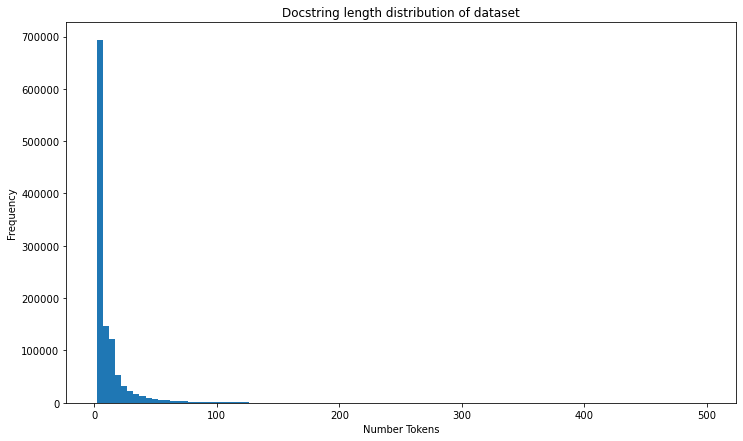

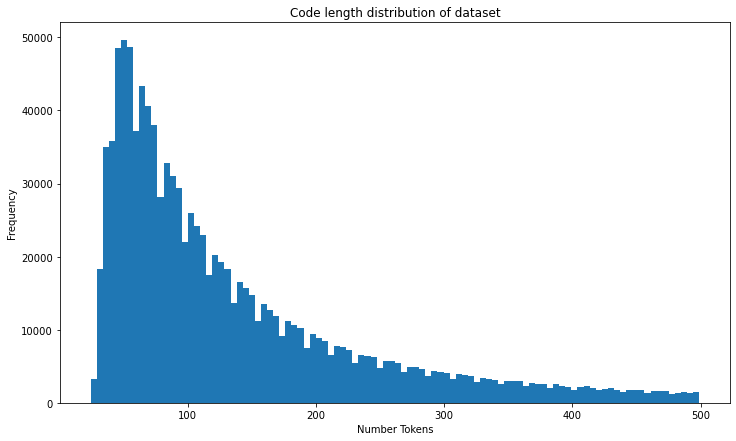


Max length function code:                1213070
Max length function docstring:              3667
Functions with less than 100 tokens in code
  and less than 100 token in docstring:       47.14%
Functions that are not methods:               32.11% (33.09% used for data)
Eligible functions:                           12.24%

Final test set will (still) have:          22176 (largest code: 6573, doc: 2682)
Final validation set will have:             3385 (14.65% of full validation set)
Final train set will have:                135242 (12.18% of full train set)


In [ ]:
code_cutoff = 100
doc_cutoff = 100

def plot_lengths(df, cutoff, name):
  length_col = f"{name} Len"

  ax = df[df[length_col] < 500][length_col].plot.hist(bins=100, figsize=(12, 7))
  ax.set_xlabel("Number Tokens")
  ax.set_title(f"{name} length distribution of dataset")
  plt.show()

pydf["Docstring Len"] = pydf["docstring_token_jagged"].str.len()
pydf["Code Len"] = pydf["code_token_jagged"].str.len()

plot_lengths(pydf, doc_cutoff, "Docstring")
plot_lengths(pydf, code_cutoff, "Code")

not_method_condition = ~(pydf["clean_code"].str.contains("^(?:async )?def\s[^(]+\(self"))
not_method_cond_corrected = ~(pydf["clean_code"].str.contains("^(?:async )?def\s[^(]+\(\s*self"))
below_limit_condition = (pydf["Docstring Len"] <= doc_cutoff) & (pydf["Code Len"] <= code_cutoff)
condition = not_method_condition & below_limit_condition

below_limit = len(pydf[below_limit_condition]) / len(pydf)
not_method = len(pydf[not_method_condition]) / len(pydf)
not_method_corrected = len(pydf[not_method_cond_corrected]) / len(pydf)
condition_percent = len(pydf[condition]) / len(pydf)
largest_code = max(pydf["Code Len"])
largest_doc = max(pydf["Docstring Len"])
full_train = len(pydf[pydf['partition'] == 'train'])
# final train data files ended up with one less example. We do not know why.
train_size = len(pydf[(pydf['partition'] == 'train') & condition]) - 1
full_test = len(pydf[pydf['partition'] == 'test'])
largest_test_code = max(pydf[(pydf['partition'] == 'test')]["Code Len"])
largest_test_doc = max(pydf[(pydf['partition'] == 'test')]["Docstring Len"])
full_val = len(pydf[pydf['partition'] == 'valid'])
val_size = len(pydf[(pydf['partition'] == 'valid') & condition])

print()
print(f"Max length function code:                {largest_code:7.0f}")
print(f"Max length function docstring:           {largest_doc:7.0f}")
print(f"Functions with less than {code_cutoff} tokens in code")
print(f"  and less than {doc_cutoff} token in docstring:  {100 * below_limit:10.2f}%")
print(f"Functions that are not methods:          {100 * not_method_corrected:10.2f}% "
      f"({100 * not_method:5.2f}% used for data)")
print(f"Eligible functions:                      {100 * condition_percent:10.2f}%")
print()

print(f"Final test set will (still) have:        {full_test:7.0f} "
      f"(largest code: {largest_test_code}, doc: {largest_test_doc})")
print(f"Final validation set will have:          {val_size:7.0f} "
      f"({100 * val_size / full_val:5.2f}% of full validation set)")
print(f"Final train set will have:               {train_size:7.0f} "
      f"({100 * train_size / full_train:5.2f}% of full train set)")

examples for a 100 token non-method function

In [ ]:
code_sample_condition = (pydf["Code Len"] == code_cutoff) & not_method_cond_corrected
code_sample_random = rng.integers(len(pydf[code_sample_condition]), size=3)
nice_bad_example = 1393

print("Examples:")
print(pydf[code_sample_condition].iloc[code_sample_random[0]]["clean_code"])
print()
print(pydf[code_sample_condition].iloc[code_sample_random[1]]["clean_code"])
print()
print(pydf[code_sample_condition].iloc[code_sample_random[2]]["clean_code"])
print("\nExample with particularly wierd names:\n")
print(pydf[code_sample_condition].iloc[nice_bad_example]["clean_code"])

Examples:
def fetch_latest_stable_version():
    response = urllib.urlopen(LATEST_VERSION_FILE_URL)
    if response.getcode() == 200:
        return response.read().strip()
    else:
        raise MongoctlException("Unable to fetch MongoDB latest stable version"
                                " from '%s' (Response code %s)" %
                                (LATEST_VERSION_FILE_URL, response.getcode()))

def main():
    parser = argparse.ArgumentParser(description='Compose a yaml file.')
    parser.add_argument(
        'root',
        type=argparse.FileType('r'),
        help='The root yaml file to compose.'
    )

    args = parser.parse_args()

    result = yaml.load(args.root, Loader=ComposeLoader)

    print(yaml.dump(result))

def _full_module_file_name_nosuffix(module_name):
    module = sys.modules[module_name]
    bn = os.path.basename(module.__file__).rpartition('.')[0]
    if not (module.__package__ is None or module.__package__ == ''):
        return module.__package__.rep

no longer jagged tokenization: use the consistent 100 token limit to make 2d array.

In [ ]:
retokenize = {"code_token": lambda df: tokenizer(df['clean_code'].tolist(),
                                                 padding='max_length',
                                                 max_length=code_cutoff).input_ids,
              "docstring_token": lambda df: tokenizer(df['docstring'].tolist(),
                                                      padding='max_length',
                                                      max_length=doc_cutoff).input_ids}

pydf = batch_read_apply("python_data_partitioned.pkl",
                        pydf_size,
                        batch_size=data_processing_batch_cpu,
                        new_columns=retokenize)

100%|████████████████████████████████████████████████████████████████████| 1160000/1160000 [03:53<00:00, 4963.65rows/s]


## Save Test, Validation data

In [ ]:
os.remove("python_data_partitioned.pkl")
pydf["Code Len"] = pydf["code_token"].str.len()

!mkdir valid
val_df = pydf[(pydf["partition"] == "valid") & condition]
val_X = np.array(val_df["docstring_token"].tolist())
val_y = np.array(val_df["code_token"].tolist())
with open("valid/python_data_validation.pkl", "wb") as f:
  pickle.dump((val_X, val_y), f)

!mkdir test
test_X = pydf[pydf["partition"] == "test"]["docstring_token"].tolist()
test_y = pydf[pydf["partition"] == "test"]["code_token"].tolist()
with open("test/python_data_test.pkl", "wb") as f:
  pickle.dump((test_X, test_y), f)

pydf[(pydf["partition"] == "train") & condition].to_pickle("python_data_train_initial.pkl")

del pydf

## Model reversing / data augentation

only for the train data.

In [ ]:
def generate_docstrings(df):
  input_ids = tokenizer(df["clean_code"].tolist(),
                        return_tensors="pt",
                        padding="max_length",
                        max_length=code_cutoff).input_ids
  generated_id_lists = model.generate(input_ids.to(pt_device)).cpu().numpy().tolist()

  # pad sequence.
  generated_doc = []
  for generated_ids in generated_id_lists:
    missing_token = doc_cutoff - len(generated_ids)
    generated_doc += [generated_ids + [0] * missing_token]

  # we tried many other cleaner / faster solutions for merging existing and generated, but got none to work.
  return [generated if original_string != "" else original_token
          for generated, original_string, original_token
          in zip(generated_doc, df["docstring"].values, df["docstring_token"].values)]

pydf_train = batch_read_apply("python_data_train_initial.pkl",
                              train_size,
                              batch_size=data_processing_batch_gpu,
                              new_columns={"docstring_token": generate_docstrings})

100%|███████████████████████████████████████████████████████████████████████| 135300/135300 [11:16<00:00, 200.03rows/s]


## Save Train

Shuffle and split train data for one-at-a-time loading later.

In [ ]:
shuffled_index = np.arange(len(pydf_train))
rng.shuffle(shuffled_index)

train_X = np.array(pydf_train["docstring_token"].tolist())
train_y = np.array(pydf_train["code_token"].tolist())

train_X = train_X[shuffled_index]
train_y = train_y[shuffled_index]

In [ ]:
!mkdir train

num_files = 5

buffer_size = math.ceil(train_X.shape[0] / num_files)
for buffer_start in range(0, train_X.shape[0], buffer_size):
  buffer_end = min(buffer_start + buffer_size, train_X.shape[0])
  buffer_train_X = train_X[buffer_start : buffer_end]
  buffer_train_y = train_y[buffer_start : buffer_end]

  with open(f"train/python_data_train_{buffer_start:07d}_to_{buffer_end:07d}.pkl", "wb") as f:
    pickle.dump((buffer_train_X, buffer_train_y), f)

In [ ]:
!zip -r python_data test valid train

shutil.rmtree("test")
shutil.rmtree("valid")
os.remove("python_data_train_initial.pkl")
shutil.rmtree("train")

  adding: test/ (188 bytes security) (stored 0%)
  adding: test/python_data_test.pkl (188 bytes security) (deflated 75%)
  adding: valid/ (188 bytes security) (stored 0%)
  adding: valid/python_data_validation.pkl (188 bytes security) (deflated 87%)
  adding: train/ (188 bytes security) (stored 0%)
  adding: train/python_data_train_0000000_to_0027049.pkl (188 bytes security) (deflated 88%)
  adding: train/python_data_train_0027049_to_0054098.pkl (188 bytes security) (deflated 88%)
  adding: train/python_data_train_0054098_to_0081147.pkl (188 bytes security) (deflated 88%)
  adding: train/python_data_train_0081147_to_0108196.pkl (188 bytes security) (deflated 88%)
  adding: train/python_data_train_0108196_to_0135242.pkl (188 bytes security) (deflated 88%)


In [ ]:
model.cpu()
del model

**checkpoint**

In [ ]:
elapsed_min = (time.time() - start_time) / 60
print(f"{elapsed_min:.0f} minutes until here")

57 minutes until here


# Training

## Setup
for both approaches

In [4]:
starting_here = True

In [5]:
if starting_here:
  vocab_size = 32100
  train_size = 135242
  val_size = 3385
  code_cutoff = 100
  doc_cutoff = 100

  if not run_local:
    from google.colab import drive
    drive.mount('/content/drive')
    !cp drive/MyDrive/python_data.zip python_data.zip
    drive.flush_and_unmount()

    !unzip python_data.zip

Mounted at /content/drive
Archive:  python_data.zip
  inflating: python_data_test.pkl    
   creating: valid/
   creating: train/
  inflating: train/python_data_train_0000000_to_0027049.pkl  
  inflating: train/python_data_train_0027049_to_0054098.pkl  
  inflating: train/python_data_train_0054098_to_0081147.pkl  
  inflating: train/python_data_train_0081147_to_0108196.pkl  
  inflating: train/python_data_train_0108196_to_0135242.pkl  
  inflating: valid/python_data_validation.pkl  
   creating: test/
  inflating: test/python_data_test.pkl  


In [ ]:
class PyData(Sequence, Dataset):

  def __init__(self, vocab_size, buffer_folder, batch_size, data_length, should_be_last=None):
    self.vocab_size = vocab_size
    self.buffer_folder = buffer_folder
    self.batch_size = batch_size
    self.data_length = data_length
    self.files = os.listdir(buffer_folder)
    self.id_current_file = 0
    self.huggingface_format = False

    # avoid getting the wrong file_length and make sure get_single_item doesnt
    # run out of data in any but the last file (where the idx >= data_length protects it).
    found_last = False
    for file_id, file_name in enumerate(self.files):
      if file_name == should_be_last:
        # moves it to the end of the list.
        self.files = self.files[:file_id] + self.files[file_id + 1:] + [self.files[file_id]]
        found_last = True
        break
    if not found_last and should_be_last is not None:
      raise ValueError("should_be_last was neither None nor presesnt in buffer_folder.")
    
    self.load_current_file()
    self.file_length = len(self.current_X)
  
  def __len__(self):
    return math.ceil(self.data_length / self.batch_size)

  def __getitem__(self, idx):

    tensorflow_format = self.getitem_tensorflow(idx)
    if self.huggingface_format:
      return {'input_ids': torch.LongTensor(tensorflow_format[0]).to(pt_device), 
              'attention_mask': torch.Tensor(self.attention_mask(tensorflow_format[0])).to(pt_device), 
              'labels': torch.LongTensor(tensorflow_format[1]).to(pt_device)}

    else:
      return tensorflow_format

  def getitem_tensorflow(self, idx):
    if isinstance(idx, int): 
      return self.get_single_batch(idx)
    
    elif isinstance(idx, slice):
      if not (isinstance(idx.start, int) and
              isinstance(idx.stop, int) and
              (isinstance(idx.step, int) or idx.step is None )):
        raise TypeError("Slice must use only int.")
      
      X_list=[]
      y_list=[]
      
      step_size = 1 if idx.step is None else idx.step 

      for i in range(idx.start, idx.stop, step_size):
        example_X, example_y = self.get_single_batch(i)
        X_list += [example_X]
        y_list += [example_y]
      
      return np.vstack(X_list), np.vstack(y_list)
    
    else:
      raise TypeError("Index type must be int or slice.")
  
  def get_single_batch(self, idx):
    X_list=[]
    y_list=[]
    for i in range(idx * self.batch_size, min((idx+1) * self.batch_size, self.data_length)):
      example_X, example_y = self.get_single_item(i)
      X_list += [example_X]
      y_list += [example_y]
    
    # We would do padding here, if code_cutoff != doc_cutoff.
    return np.array(X_list), np.array(y_list)

  def get_single_item(self, idx):
    if idx < 0 or idx >= self.data_length:
      raise IndexError("idx out of range.")
    
    requested_file = idx // self.file_length
    if requested_file != self.id_current_file:
      self.id_current_file = requested_file
      self.load_current_file()
      
    idx_in_file = idx % self.file_length
    example_X, example_y = self.current_X[idx_in_file], self.current_y[idx_in_file]

    return (example_X, self.onehot(example_y))

  def onehot(self, example):
    # Huggingface doesn't need onehot encoding.
    if self.huggingface_format:
      return example
    encoded=np.zeros((len(example), self.vocab_size))
    encoded[np.arange(len(example)), example]=1
    return encoded
  
  def attention_mask(self, input_ids):
    return (input_ids != 0).astype(float)

  def load_current_file(self):
    path = os.path.join(self.buffer_folder, self.files[self.id_current_file])
    with open(path, 'rb') as f:
      self.current_X, self.current_y = pickle.load(f) 

In [ ]:
pydata_validation = PyData(vocab_size, "valid", batch_size_tf, val_size)
pydata_train = PyData(vocab_size, "train", batch_size_tf, train_size,
                      should_be_last="python_data_train_0108196_to_0135242.pkl") 

Configuration for evaluation as well as training

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp /content/drive/MyDrive/tf_checkpoint.zip ./

In [ ]:
!unzip /content/tf_checkpoint.zip

In [9]:
!cp /content/drive/MyDrive/hf_checkpoint.zip ./

In [10]:
!unzip /content/hf_checkpoint.zip

Archive:  /content/hf_checkpoint.zip
  inflating: after-225-epoch/config.json  
  inflating: after-225-epoch/pytorch_model.bin  
  inflating: after-225-epoch/training_args.bin  


In [11]:
tf_checkpoint_path = 'tf_checkpoint'
ft_model_at = 'tf_checkpoint_24'

hf_checkpoint_path = "hf_checkpoint"
hf_model_at = os.path.join(hf_checkpoint_path, "after-225-epoch")

In [12]:
hf_model_at = "after-225-epoch"

## LSTM (Keras)
We use the basic bi-LSTM architechture as introduced in the lecture. We decided to employ a 64 long embedding layer and just a single LSMT layer with 32 units to keep the complexity relatively low.

For the implementation we used Keras as we had the most amount of experience with it.

In [13]:
def create_lstm():
  model = Sequential([Input(shape=(doc_cutoff,)),
                      Embedding(vocab_size, 64, input_length=doc_cutoff),
                      Bidirectional(LSTM(32, return_sequences=True)),
                      TimeDistributed(Dense(vocab_size, activation='softmax'))])

  optimizer = keras.optimizers.Adam(learning_rate=1e-6)
  model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=["acc"])

  return model

In [ ]:
model = create_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           2054400   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 64)           24832     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 32100)        2086500   
Total params: 4,165,732
Trainable params: 4,165,732
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ft_model_at
)

In [ ]:
model.fit(pydata_train, validation_data=pydata_validation, callbacks=[model_checkpoint_callback] , epochs=24)

Epoch 1/32
5410/5410 [==============================] - 2017s 372ms/step - loss: 10.3709 - acc: 0.0044 - val_loss: 10.3396 - val_acc: 0.0649


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 2/32
5410/5410 [==============================] - 2024s 374ms/step - loss: 10.3034 - acc: 0.1883 - val_loss: 10.1316 - val_acc: 0.2111


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 3/32
5410/5410 [==============================] - 2050s 379ms/step - loss: 10.0012 - acc: 0.1395 - val_loss: 9.6930 - val_acc: 0.0154


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 4/32
5410/5410 [==============================] - 2158s 399ms/step - loss: 9.5371 - acc: 0.0103 - val_loss: 9.2263 - val_acc: 0.0104


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 5/32
5410/5410 [==============================] - 2226s 411ms/step - loss: 9.0687 - acc: 0.0100 - val_loss: 8.7717 - val_acc: 0.0101


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 6/32
5410/5410 [==============================] - 2241s 414ms/step - loss: 8.6191 - acc: 0.0100 - val_loss: 8.3285 - val_acc: 0.0100


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 7/32
5410/5410 [==============================] - 2238s 414ms/step - loss: 8.1782 - acc: 0.0100 - val_loss: 7.8910 - val_acc: 0.0100


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 8/32
5410/5410 [==============================] - 2239s 414ms/step - loss: 7.7442 - acc: 0.0100 - val_loss: 7.4686 - val_acc: 0.0100


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 9/32
5410/5410 [==============================] - 2232s 413ms/step - loss: 7.3279 - acc: 0.0112 - val_loss: 7.0694 - val_acc: 0.2591


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 10/32
5410/5410 [==============================] - 2229s 412ms/step - loss: 6.9378 - acc: 0.2732 - val_loss: 6.6999 - val_acc: 0.2978


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 11/32
5410/5410 [==============================] - 2262s 418ms/step - loss: 6.5792 - acc: 0.3002 - val_loss: 6.3644 - val_acc: 0.3166


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 12/32
5410/5410 [==============================] - 2255s 417ms/step - loss: 6.2539 - acc: 0.3154 - val_loss: 6.0657 - val_acc: 0.3359


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 13/32
5410/5410 [==============================] - 2231s 412ms/step - loss: 5.9688 - acc: 0.3310 - val_loss: 5.8062 - val_acc: 0.3359


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 14/32
5410/5410 [==============================] - 2266s 419ms/step - loss: 5.7227 - acc: 0.3305 - val_loss: 5.5842 - val_acc: 0.3359


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 15/32
5410/5410 [==============================] - 2286s 423ms/step - loss: 5.5110 - acc: 0.3312 - val_loss: 5.3969 - val_acc: 0.3359


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 16/32
5410/5410 [==============================] - 2227s 412ms/step - loss: 5.3334 - acc: 0.3310 - val_loss: 5.2397 - val_acc: 0.3359


INFO:tensorflow:Assets written to: tf_checkpoint\assets


INFO:tensorflow:Assets written to: tf_checkpoint\assets


Epoch 17/32
2602/5410 [=============>................] - ETA: 19:39 - loss: 5.1979 - acc: 0.3321

KeyboardInterrupt: ignored

## BERT-BERT (🤗 Huggingface)

### 🤗 Trainer optimization

By default the 🤗 Trainer object keeps the predictions used for evaluation in one-hot format. That is not feasable on any of the machines we use for training.
To reduce the memory usage we only evaluate on the most likely token at each position (less good than beam search)

In [ ]:
class TrainerWithAlteredEval(Trainer):
    """
    Alters the evaluation / predicion loop behavior to reduce array size as suggested in
    https://github.com/huggingface/transformers/issues/8476.
    """

    def evaluation_loop(
        self,
        dataloader: DataLoader,
        description: str,
        prediction_loss_only: Optional[bool] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
    ) -> EvalLoopOutput:
        """
        Prediction/evaluation loop, shared by `Trainer.evaluate()` and `Trainer.predict()`.
        Works both with or without labels.
        """
        args = self.args

        prediction_loss_only = prediction_loss_only if prediction_loss_only is not None else args.prediction_loss_only

        # if eval is called w/o train init deepspeed here
        if args.deepspeed and not self.deepspeed:

            # XXX: eval doesn't have `resume_from_checkpoint` arg but we should be able to do eval
            # from the checkpoint eventually
            deepspeed_engine, _, _ = deepspeed_init(
                self, num_training_steps=0, resume_from_checkpoint=None, inference=True
            )
            self.model = deepspeed_engine.module
            self.model_wrapped = deepspeed_engine
            self.deepspeed = deepspeed_engine

        model = self._wrap_model(self.model, training=False)

        # if full fp16 or bf16 eval is wanted and this ``evaluation`` or ``predict`` isn't called
        # while ``train`` is running, cast it to the right dtype first and then put on device
        if not self.is_in_train:
            if args.fp16_full_eval:
                model = model.to(dtype=torch.float16, device=args.device)
            elif args.bf16_full_eval:
                model = model.to(dtype=torch.bfloat16, device=args.device)

        batch_size = dataloader.batch_size

        #logger.info(f"***** Running {description} *****")
        #if isinstance(dataloader.dataset, collections.abc.Sized):
            #logger.info(f"  Num examples = {self.num_examples(dataloader)}")
        #else:
            #logger.info("  Num examples: Unknown")
        #logger.info(f"  Batch size = {batch_size}")

        model.eval()

        self.callback_handler.eval_dataloader = dataloader
        # Do this before wrapping.
        eval_dataset = dataloader.dataset

        #if is_torch_tpu_available():
        #    dataloader = pl.ParallelLoader(dataloader, [args.device]).per_device_loader(args.device)

        if args.past_index >= 0:
            self._past = None

        # Initialize containers
        # losses/preds/labels on GPU/TPU (accumulated for eval_accumulation_steps)
        losses_host = None
        preds_host = None
        labels_host = None
        # losses/preds/labels on CPU (final containers)
        all_losses = None
        all_preds = None
        all_labels = None
        # Will be useful when we have an iterable dataset so don't know its length.

        observed_num_examples = 0
        # Main evaluation loop
        for step, inputs in enumerate(dataloader):
            # Update the observed num examples
            observed_batch_size = find_batch_size(inputs)
            if observed_batch_size is not None:
                observed_num_examples += observed_batch_size
                # For batch samplers, batch_size is not known by the dataloader in advance.
                if batch_size is None:
                    batch_size = observed_batch_size

            # Prediction step
            loss, logits, labels = self.prediction_step(model, inputs, prediction_loss_only, ignore_keys=ignore_keys)

            # Update containers on host
            if loss is not None:
                losses = self._nested_gather(loss.repeat(batch_size))
                losses_host = losses if losses_host is None else torch.cat((losses_host, losses), dim=0)
            if logits is not None:
                logits = self._pad_across_processes(logits)
                logits = self._nested_gather(logits)
                #preds_host = logits if preds_host is None else nested_concat(preds_host, logits, padding_index=-100)
                # line above was changed to:
                if isinstance(logits, tuple):
                    logits_reduced = np.argmax(logits[0].cpu(), axis=-1)
                else:
                    logits_reduced = np.argmax(logits.cpu(), axis=-1)
                preds_host = logits_reduced if preds_host is None else nested_concat(preds_host, logits_reduced, padding_index=-100)
            if labels is not None:
                labels = self._pad_across_processes(labels)
                labels = self._nested_gather(labels)
                labels_host = labels if labels_host is None else nested_concat(labels_host, labels, padding_index=-100)
            self.control = self.callback_handler.on_prediction_step(args, self.state, self.control)

            # Gather all tensors and put them back on the CPU if we have done enough accumulation steps.
            if args.eval_accumulation_steps is not None and (step + 1) % args.eval_accumulation_steps == 0:
                if losses_host is not None:
                    losses = nested_numpify(losses_host)
                    all_losses = losses if all_losses is None else np.concatenate((all_losses, losses), axis=0)
                if preds_host is not None:
                    logits = nested_numpify(preds_host)
                    all_preds = logits if all_preds is None else nested_concat(all_preds, logits, padding_index=-100)
                if labels_host is not None:
                    labels = nested_numpify(labels_host)
                    all_labels = (
                        labels if all_labels is None else nested_concat(all_labels, labels, padding_index=-100)
                    )

                # Set back to None to begin a new accumulation
                losses_host, preds_host, labels_host = None, None, None

        if args.past_index and hasattr(self, "_past"):
            # Clean the state at the end of the evaluation loop
            delattr(self, "_past")

        # Gather all remaining tensors and put them back on the CPU
        if losses_host is not None:
            losses = nested_numpify(losses_host)
            all_losses = losses if all_losses is None else np.concatenate((all_losses, losses), axis=0)
        if preds_host is not None:
            logits = nested_numpify(preds_host)
            all_preds = logits if all_preds is None else nested_concat(all_preds, logits, padding_index=-100)
        if labels_host is not None:
            labels = nested_numpify(labels_host)
            all_labels = labels if all_labels is None else nested_concat(all_labels, labels, padding_index=-100)

        # Number of samples
        if not isinstance(eval_dataset, IterableDataset):
            num_samples = len(eval_dataset)
        # The instance check is weird and does not actually check for the type, but whether the dataset has the right
        # methods. Therefore we need to make sure it also has the attribute.
        elif isinstance(eval_dataset, IterableDatasetShard) and hasattr(eval_dataset, "num_examples"):
            num_samples = eval_dataset.num_examples
        else:
            num_samples = observed_num_examples

        # Number of losses has been rounded to a multiple of batch_size and in a distributed training, the number of
        # samplers has been rounded to a multiple of batch_size, so we truncate.
        if all_losses is not None:
            all_losses = all_losses[:num_samples]
        if all_preds is not None:
            all_preds = nested_truncate(all_preds, num_samples)
        if all_labels is not None:
            all_labels = nested_truncate(all_labels, num_samples)

        # Metrics!
        if self.compute_metrics is not None and all_preds is not None and all_labels is not None:
            metrics = self.compute_metrics(EvalPrediction(predictions=all_preds, label_ids=all_labels))
        else:
            metrics = {}

        # To be JSON-serializable, we need to remove numpy types or zero-d tensors
        metrics = denumpify_detensorize(metrics)

        if all_losses is not None:
            metrics[f"{metric_key_prefix}_loss"] = all_losses.mean().item()

        # Prefix all keys with metric_key_prefix + '_'
        for key in list(metrics.keys()):
            if not key.startswith(f"{metric_key_prefix}_"):
                metrics[f"{metric_key_prefix}_{key}"] = metrics.pop(key)

        return EvalLoopOutput(predictions=all_preds, label_ids=all_labels, metrics=metrics, num_samples=num_samples)
    
    def prediction_loop(
        self,
        dataloader: DataLoader,
        description: str,
        prediction_loss_only: Optional[bool] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
    ) -> PredictionOutput:
        """
        Prediction/evaluation loop, shared by `Trainer.evaluate()` and `Trainer.predict()`.
        Works both with or without labels.
        """
        args = self.args

        if not isinstance(dataloader.dataset, collections.abc.Sized):
            raise ValueError("dataset must implement __len__")
        prediction_loss_only = prediction_loss_only if prediction_loss_only is not None else args.prediction_loss_only

        # if eval is called w/o train init deepspeed here
        if args.deepspeed and not self.deepspeed:

            # XXX: eval doesn't have `resume_from_checkpoint` arg but we should be able to do eval
            # from the checkpoint eventually
            deepspeed_engine, _, _ = deepspeed_init(self, num_training_steps=0, resume_from_checkpoint=None)
            self.model = deepspeed_engine.module
            self.model_wrapped = deepspeed_engine
            self.deepspeed = deepspeed_engine
            # XXX: we don't need optim/sched for inference, but this needs to be sorted out, since
            # for example the Z3-optimizer is a must for zero3 to work even for inference - what we
            # don't need is the deepspeed basic optimizer which is self.optimizer.optimizer
            deepspeed_engine.optimizer.optimizer = None
            deepspeed_engine.lr_scheduler = None

        model = self._wrap_model(self.model, training=False)

        # if full fp16 or bf16 eval is wanted and this ``evaluation`` or ``predict`` isn't called
        # while ``train`` is running, cast it to the right dtype first and then put on device
        if not self.is_in_train:
            if args.fp16_full_eval:
                model = model.to(dtype=torch.float16, device=args.device)
            elif args.bf16_full_eval:
                model = model.to(dtype=torch.bfloat16, device=args.device)

        batch_size = dataloader.batch_size
        num_examples = self.num_examples(dataloader)
        #logger.info(f"***** Running {description} *****")
        #logger.info(f"  Num examples = {num_examples}")
        #logger.info(f"  Batch size = {batch_size}")
        losses_host: torch.Tensor = None
        preds_host: Union[torch.Tensor, List[torch.Tensor]] = None
        labels_host: Union[torch.Tensor, List[torch.Tensor]] = None

        world_size = max(1, args.world_size)

        eval_losses_gatherer = DistributedTensorGatherer(world_size, num_examples, make_multiple_of=batch_size)
        if not prediction_loss_only:
            # The actual number of eval_sample can be greater than num_examples in distributed settings (when we pass
            # a batch size to the sampler)
            make_multiple_of = None
            if hasattr(dataloader, "sampler") and isinstance(dataloader.sampler, SequentialDistributedSampler):
                make_multiple_of = dataloader.sampler.batch_size
            preds_gatherer = DistributedTensorGatherer(world_size, num_examples, make_multiple_of=make_multiple_of)
            labels_gatherer = DistributedTensorGatherer(world_size, num_examples, make_multiple_of=make_multiple_of)

        model.eval()

        #if is_torch_tpu_available():
        #    dataloader = pl.ParallelLoader(dataloader, [args.device]).per_device_loader(args.device)

        if args.past_index >= 0:
            self._past = None

        self.callback_handler.eval_dataloader = dataloader

        for step, inputs in enumerate(dataloader):
            loss, logits, labels = self.prediction_step(model, inputs, prediction_loss_only, ignore_keys=ignore_keys)
            if loss is not None:
                losses = loss.repeat(batch_size)
                losses_host = losses if losses_host is None else torch.cat((losses_host, losses), dim=0)
            if logits is not None:
                #preds_host = logits if preds_host is None else nested_concat(preds_host, logits, padding_index=-100)
                # line above was changed to:
                if isinstance(logits, tuple):
                    logits_reduced = np.argmax(logits[0].cpu(), axis=-1)
                else:
                    logits_reduced = np.argmax(logits.cpu(), axis=-1)
                preds_host = logits_reduced if preds_host is None else nested_concat(preds_host, logits_reduced, padding_index=-100)
            if labels is not None:
                labels_host = labels if labels_host is None else nested_concat(labels_host, labels, padding_index=-100)
            self.control = self.callback_handler.on_prediction_step(args, self.state, self.control)

            # Gather all tensors and put them back on the CPU if we have done enough accumulation steps.
            if args.eval_accumulation_steps is not None and (step + 1) % args.eval_accumulation_steps == 0:
                eval_losses_gatherer.add_arrays(self._gather_and_numpify(losses_host, "eval_losses"))
                if not prediction_loss_only:
                    preds_gatherer.add_arrays(self._gather_and_numpify(preds_host, "eval_preds"))
                    labels_gatherer.add_arrays(self._gather_and_numpify(labels_host, "eval_label_ids"))

                # Set back to None to begin a new accumulation
                losses_host, preds_host, labels_host = None, None, None

        if args.past_index and hasattr(self, "_past"):
            # Clean the state at the end of the evaluation loop
            delattr(self, "_past")

        # Gather all remaining tensors and put them back on the CPU
        eval_losses_gatherer.add_arrays(self._gather_and_numpify(losses_host, "eval_losses"))
        if not prediction_loss_only:
            preds_gatherer.add_arrays(self._gather_and_numpify(preds_host, "eval_preds"))
            labels_gatherer.add_arrays(self._gather_and_numpify(labels_host, "eval_label_ids"))

        eval_loss = eval_losses_gatherer.finalize()
        preds = preds_gatherer.finalize() if not prediction_loss_only else None
        label_ids = labels_gatherer.finalize() if not prediction_loss_only else None

        if self.compute_metrics is not None and preds is not None and label_ids is not None:
            metrics = self.compute_metrics(EvalPrediction(predictions=preds, label_ids=label_ids))
        else:
            metrics = {}

        # To be JSON-serializable, we need to remove numpy types or zero-d tensors
        metrics = denumpify_detensorize(metrics)

        if eval_loss is not None:
            metrics[f"{metric_key_prefix}_loss"] = eval_loss.mean().item()

        # Prefix all keys with metric_key_prefix + '_'
        for key in list(metrics.keys()):
            if not key.startswith(f"{metric_key_prefix}_"):
                metrics[f"{metric_key_prefix}_{key}"] = metrics.pop(key)

        return PredictionOutput(predictions=preds, label_ids=label_ids, metrics=metrics)

### Training

In [ ]:
if starting_here:
  tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-base-multi-sum")

prajjwal1_bert_small_param = {
  "_name_or_path": "custom-bert-small",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": tokenizer.bos_token_id,
  "eos_token_id": tokenizer.eos_token_id,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": tokenizer.pad_token_id,
  "position_embedding_type": "absolute",
  "sep_token_id": tokenizer.sep_token_id,
  "type_vocab_size": 2,
  "use_cache": True,
  "vocab_size": tokenizer.vocab_size
}

In [ ]:
config_encoder = BertConfig(**prajjwal1_bert_small_param)
config_decoder = BertConfig(**prajjwal1_bert_small_param)

config = EncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)
config.decoder_start_token_id = tokenizer.bos_token_id

model = EncoderDecoderModel(config=config).to(pt_device)

config_encoder = model.config.encoder
config_decoder = model.config.decoder
config_decoder.is_decoder = True
config_decoder.add_cross_attention = True

# These values seem to not be set in the constructor.
for config_to_adjust in (config, config_encoder, config_decoder):
  config_to_adjust.vocab_size = tokenizer.vocab_size
  config_to_adjust.bos_token_id = tokenizer.bos_token_id
  config_to_adjust.eos_token_id = tokenizer.eos_token_id
  config_to_adjust.pad_token_id = tokenizer.pad_token_id
  config_to_adjust.sep_token_id = tokenizer.sep_token_id

In [ ]:
pydata_validation.huggingface_format = True
pydata_train.huggingface_format = True

Some very simple metrics that we can implement ourselfs.

In [ ]:
problematic_token = tokenizer("def(,_\n ( , _ \n")['input_ids'] + [0]

def can_complie(source_code_token):
  source_code = tokenizer.decode(source_code_token, skip_special_tokens=True)
  valid = True

  try:
    ast.parse(source_code)
  except SyntaxError:
    valid = False
  
  return valid

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  simple_accs, problematics, matches, complies = [], [], [], []

  for prediction, label in zip(predictions, labels):
    # list of correct / not correct prediction (incl. padding), becomes percentage in return.
    simple_accs += [(prediction == label).astype(int)]
    # with higher learning rates the model learned to reproduce the most frequent
    # tokens. This serves as an indicator for us, whether this is currently happening.
    problematics += [sum(np.count_nonzero(prediction == token) / prediction.size
                     for token in problematic_token)]
    # for accuracy using a whole function as the smallest unit. Stayed 0 in the whole
    # training. The missing beam search also did not help.
    matches += [1 if np.all(prediction == label) else 0]
    # for percent of eval dataset that could run as python code. Also stayed 0, because
    # of missing beam search. The examples generated using beamsearch largely compiled.
    complies += [1 if can_complie(prediction) else 0]
  
  return {"simple_acc": np.mean(simple_accs),
          "exact_match": np.mean(matches),
          "problem_token_perc": np.mean(problematics),
          "num_compling": np.sum(complies),
          "compling_perc": np.mean(complies)}

In [ ]:
training_args = TrainingArguments(
    output_dir=hf_checkpoint_path,
    save_total_limit=1,
    num_train_epochs=225,
    per_device_train_batch_size=1, # batch size must stay 1, because of our implementation
    gradient_accumulation_steps=10,# this puts the effective batch size at 10 * 25 = 250
    warmup_steps=1000,
    learning_rate=0.000002,
    logging_dir="./logs",
    save_steps=1000,
    logging_steps=100,
    logging_first_step=True,
    evaluation_strategy="epoch",
    eval_accumulation_steps=10,
    per_device_eval_batch_size=1,
    dataloader_pin_memory = False  # for us this fixes an error during the training
) 

trainer = TrainerWithAlteredEval(
    model=model,
    args=training_args,
    train_dataset=pydata_train,
    eval_dataset=pydata_validation,
    data_collator=lambda x:x[0],   # like the batchsize this is neede bacuase of our implementation
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

# Evaluation

## Loading data / models

In [15]:
evaluation_folder = "evaluation-results"
evaluation_for_model_at = hf_model_at

hf_model = AutoModelForSeq2SeqLM.from_pretrained(hf_model_at).to(pt_device)
tf_model = create_lstm()
tf_model.load_weights('tf_checkpoint_24/')
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-base-multi-sum")

with open('test/python_data_test.pkl', 'rb') as f:
  pydata_test_X, pydata_test_y = pickle.load(f)

Downloading:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/687k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

In [ ]:
results_test = []
results_user = []

for (dirpath, dirnames, filenames) in os.walk(evaluation_folder):
  for filename in filenames:
    with open(os.path.join(dirpath, filename), 'rb') as f:
      result = eval(f.read())

      results_test += result[:10]
      results_user += result[10:]

results_test = pd.DataFrame(results_test)
results_user = pd.DataFrame(results_user)[[1, 2, 3, 4]]

In [ ]:
results_test.columns = ["id in dataset", "code quality", "fitting docstring"]
results_test["id in dataset"] = results_test["id in dataset"].apply(lambda id: id[5:])

results_user.columns = ["code quality", "fitting docstring", "docstring_token", "code_token"]

In [ ]:
print(f"Datapoints for Testset:                {len(results_test):3.0f} "
      f"(10 questions x {len(results_test) // 10} participants)")
print(f"Datapoints for user chosen docstring: {len(results_user):3.0f} "
      f"( 5 questions x {len(results_user) // 5} participants)")

Datapoints for Testset:                120 (10 questions x 12 participants)
Datapoints for user choosen docstring:  60 ( 5 questions x 12 participants)


In [ ]:
results_test.head()

,id in dataset,code quality,fitting docstring
0,18695,3,1
1,17178,3,1
2,9730,1,1
3,3827,1,1
4,12568,1,1


In [ ]:
results_user.head()

,code quality,fitting docstring,docstring_token,code_token
0,3,2,"[1, 7018, 326, 769, 434, 392, 526, 18, 2]","[1, 1, 536, 769, 67, 2469, 12, 1126, 4672, 203..."
1,3,3,"[1, 1564, 309, 460, 353, 392, 2144, 18, 2]","[1, 1, 536, 353, 67, 1132, 12, 1132, 4672, 203..."
2,2,1,"[1, 30296, 434, 2795, 924, 18, 2]","[1, 1, 536, 336, 67, 1132, 12, 1132, 21, 16, 4..."
3,1,1,"[1, 990, 1122, 930, 434, 526, 18, 2]","[1, 1, 536, 1122, 67, 2956, 12, 1132, 4672, 20..."
4,3,4,"[1, 1684, 526, 18, 2]","[1, 1, 536, 526, 67, 1126, 12, 1132, 4672, 203..."


## Implementation

In [ ]:
def plot_manual(evaluation_test, evaluation_user):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  test_code_x = np.array(evaluation_test["code quality"].value_counts().sort_index().keys())
  test_code_y = np.array(evaluation_test["code quality"].value_counts().sort_index().values)
  user_code_x = np.array(evaluation_user["code quality"].value_counts().sort_index().keys())
  user_code_y = np.array(evaluation_user["code quality"].value_counts().sort_index().values)

  ax1.bar(test_code_x - 0.15, 100 * test_code_y / len(evaluation_test), width=0.3, label="testdata")
  ax1.bar(user_code_x + 0.15, 100 * user_code_y / len(evaluation_user), width=0.3, label="user give docstring")
  ax1.set_ylabel("% votes")
  ax1.set_xlabel("rating")
  ax1.set_title("How would you rate the code quality?")
  ax1.legend()
  ax1.grid()

  test_doc_x = np.array(evaluation_test["fitting docstring"].value_counts().sort_index().keys())
  test_doc_y = np.array(evaluation_test["fitting docstring"].value_counts().sort_index().values)
  user_doc_x = np.array(evaluation_user["fitting docstring"].value_counts().sort_index().keys())
  user_doc_y = np.array(evaluation_user["fitting docstring"].value_counts().sort_index().values)

  ax2.bar(test_doc_x - 0.15, 100 * test_doc_y / len(evaluation_test), width=0.3, label="testdata")
  ax2.bar(user_doc_x + 0.15, 100 * user_doc_y / len(evaluation_user), width=0.3, label="user give docstring")
  ax2.set_ylabel("% votes")
  ax2.set_xlabel("rating")
  ax2.set_title("How well does the code fit the given docstring?")
  ax2.legend()
  ax2.grid()

In [14]:
def get_hf_code(input_ids_batch):
  generated = hf_model.generate(torch.LongTensor(input_ids_batch).to(pt_device),
                                max_length=150,
                                num_beams=5,
                                repetition_penalty=1.4,
                                no_repeat_ngram_size=4
                                )

  return tokenizer.batch_decode(generated, skip_special_tokens=True), generated

def get_tf_code(input_ids_batch):
  generated = tf_model.predict(input_ids_batch)
  token_ids = np.argmax(generated, axis=1)
  
  return tokenizer.batch_decode(token_ids, skip_special_tokens=True), token_ids

def get_test_outputs(test_X, test_y):
  
  outputs = {}

  for model_name, model_predict in [("Transformer", get_hf_code), ("LSTM", get_tf_code)]:
    string_outputs, token_outputs = [], []

    for batch_start in tqdm(range(0, len(test_X), data_processing_batch_gpu)):
      
      batch = test_X[batch_start : batch_start + data_processing_batch_gpu]
      batch = [example[:100] + [0] * (100 - len(example)) for example in batch]
      string_output, token_output = model_predict(np.array(batch))
      string_outputs += [string_output]
      token_outputs += [token_output]
    
    outputs[model_name] = (string_outputs, token_outputs)
  return outputs    

In [ ]:
model_outputs = get_test_outputs(pydata_test_X, pydata_test_y)
with open('test/python_data_test_model_generated.pkl', 'wb') as f:
  pickle.dump(model_outputs, f)

100%|██████████| 222/222 [09:15<00:00,  2.50s/it]


In [ ]:
with open('test/python_data_test_model_generated.pkl', 'rb') as f:
  model_outputs = pickle.load(f)

In [ ]:
with open('test/python_data_test_model_generated.pkl', 'rb') as f:
  model_outputs = pickle.load(f)

model_outputs["LSTM"] = (["".join(output) for output in model_outputs["LSTM"][0]],
                         np.array(model_outputs["LSTM"][1]))
model_outputs["Transformer"] = (["".join(output) for output in model_outputs["Transformer"][0]],
                                np.array([tensor.cpu().numpy().tolist()[:100] + [0] * (100 - len(tensor))
                                          for tensor in model_outputs["Transformer"][1]]))
correct_outputs = np.array([example[:100] + [0] * (100 - len(example)) for example in pydata_test_y])

In [ ]:
model_outputs["LSTM"][1].shape

(222, 100)

In [ ]:
compute_metrics((model_outputs["LSTM"][1], correct_outputs))

{'simple_acc': 0.026801801801801802,
 'exact_match': 0.0,
 'problem_token_perc': 0.9808558558558561,
 'num_compling': 0,
 'compling_perc': 0.0}

## Manual Evaluation

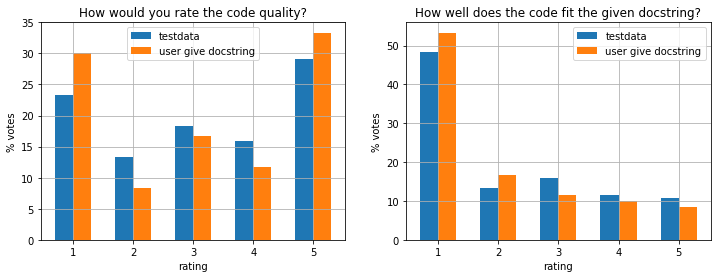

In [ ]:
plot_manual(results_test, results_user)